In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import h5py

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import plot_reconstructed_data_KS, plot_latent_states_KS 

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)

# KS System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '005'

    # making ae save directory
    dir_name_pod = os.getcwd() + dir_sep + 'saved_pod'
    if not os.path.isdir(dir_name_pod):
        os.makedirs(dir_name_pod)

    counter = 0
    while True:
        dir_check = 'pod_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_pod + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_pod = dir_name_pod + dir_sep + dir_check
    os.makedirs(dir_name_pod)
    os.makedirs(dir_name_pod+dir_sep+'plots')
else:
    # some paramaters
    dir_name_pod = os.getcwd()+'{ds}saved_pod{ds}pod_015'.format(ds=dir_sep)

    with open(dir_name_pod + dir_sep + 'pod_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    pod_data_with_params = params_dict['pod_data_with_params']
    normalizeforpod_flag = params_dict['normalizeforpod_flag']
    normalization_constant_arr_poddata = params_dict['normalization_constant_arr_poddata']
    if os.path.exists(dir_name_pod+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_pod+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_poddata = fl['normalization_constant_arr_poddata'][0]

print('dir_name_pod:', dir_name_pod)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_pod: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_pod/pod_000
normalize_flag_ogdata: False


In [11]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [12]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

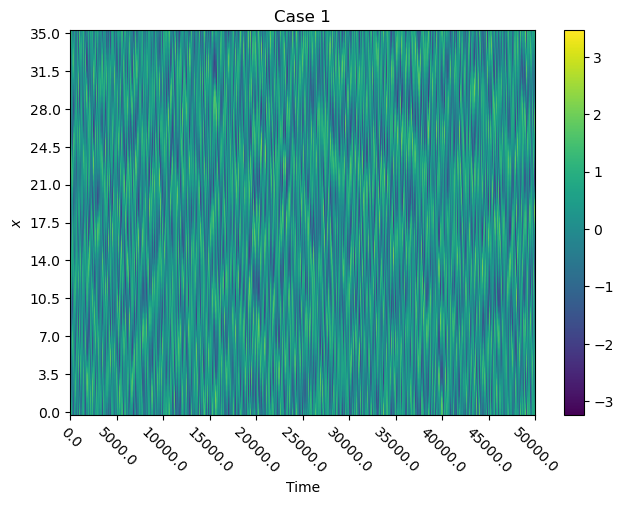

In [13]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforpod_flag = True
    normalization_type = 'global_stddev' # could be 'stddev' or 'minmax' or 'global_stddev'
    stddev_multiplier = 3
    
    pod_data_with_params = False # whether to feed in the parameters to the POD along with the data?

    if pod_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
    
    normalization_constant_arr_poddata = None
    if normalizeforpod_flag == True:
        norm_shape = numpoints_xgrid
        if pod_data_with_params == True:
            norm_shape += params_mat.shape[1]
        normalization_constant_arr_poddata = np.empty(shape=(2, norm_shape), dtype=FTYPE)
        if normalization_type == 'stddev':
            for i in range(norm_shape):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                if sample_std <= 1e-9:
                    sample_std = 1.0
                normalization_constant_arr_poddata[0, i] = sample_mean
                normalization_constant_arr_poddata[1, i] = stddev_multiplier*sample_std
        elif normalization_type == 'minmax':
            for i in range(norm_shape):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min
                    sample_max = sample_min + 1
                normalization_constant_arr_poddata[0, i] = sample_min
                normalization_constant_arr_poddata[1, i] = sample_max - sample_min
        elif normalization_type == 'global_stddev':
            sample_std_all = np.mean(np.std(all_data, axis=0))
            for i in range(norm_shape):
                sample_mean = np.mean(all_data[:, i])
                sample_std = sample_std_all
                if sample_std <= 1e-9:
                    sample_std = 1.0
                normalization_constant_arr_poddata[0, i] = sample_mean
                normalization_constant_arr_poddata[1, i] = stddev_multiplier*sample_std
        for i in range(norm_shape):
            all_data[:, i] -= normalization_constant_arr_poddata[0, i]
            all_data[:, i] /= normalization_constant_arr_poddata[1, i]
            
    # saving sim data
    pod_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforpod_flag':normalizeforpod_flag,
        'normalization_constant_arr_poddata':normalization_constant_arr_poddata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'pod_data_with_params':pod_data_with_params,
        'module':'POD',
    }
    with open(dir_name_pod+dir_sep+'pod_data.txt', 'w') as f:
        f.write(str(pod_data))
    np.savez(
        dir_name_pod+dir_sep+'normalization_data',
        normalization_constant_arr_poddata=[normalization_constant_arr_poddata],
    )
else:
    if pod_data_with_params == True:
        all_data = all_data[:, 0:numpoints_xgrid]
    if normalizeforpod_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_poddata[0, i]
            all_data[:, i] /= normalization_constant_arr_poddata[1, i]

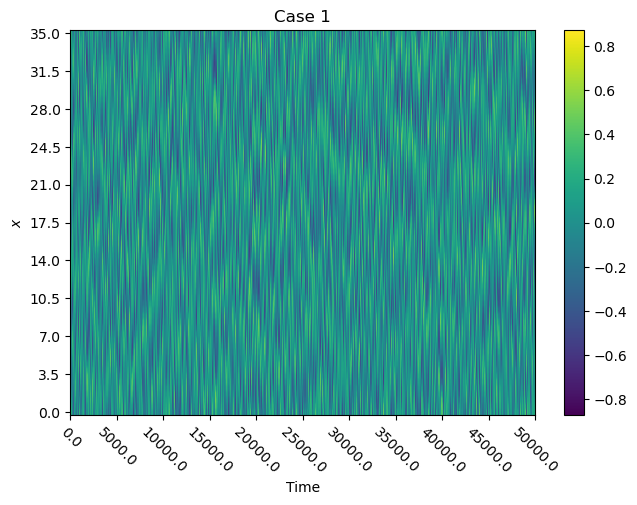

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

# POD

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    num_latent_dims = 16
    train_split = 0.9
    test_split = 1 - train_split
    
    # saving training params
    training_specific_params = {
        'prng_seed':prng_seed,
        'train_split':train_split,
    }

    with open(dir_name_pod+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    
    test_split = 1 - train_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( train_split*num_samples )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape, dtype=FTYPE)

testing_data = np.empty(shape=testing_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( train_split*num_samples )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    num_test = num_samples-num_train+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    pod_centering_means = np.mean(training_data, dtype=FTYPE)
    meancentered_training_data = training_data - pod_centering_means
    covmat_training_data = meancentered_training_data.transpose() @ meancentered_training_data
    covmat_training_data /= FTYPE(meancentered_training_data.shape[0] - 1)
    
    eigenvals, eigenvecs = np.linalg.eig(covmat_training_data)
    sort_idx = np.argsort(np.abs(eigenvals))
    eigenvals = eigenvals[sort_idx]
    eigenvecs = eigenvecs[:, sort_idx]
    
    Wl = eigenvecs[:, -num_latent_dims:]
    
    np.savez(
        dir_name_pod + '/Wl',
        Wl=Wl,
        pod_centering_means=pod_centering_means,
    )
    
    coeffs_training = (training_data - pod_centering_means) @ Wl
    reconstructed_training = coeffs_training @ Wl.transpose() + pod_centering_means
    recon_error_mse_training = np.mean((reconstructed_training - training_data)**2)
    
    coeffs_testing = (testing_data - pod_centering_means) @ Wl
    reconstructed_testing = coeffs_testing @ Wl.transpose() + pod_centering_means
    recon_error_mse_testing = np.mean((reconstructed_testing - testing_data)**2)
    
    lines = 'reconstruction MSE (training data) : {}\n'.format(recon_error_mse_training)
    lines += 'reconstruction MSE (testing data) : {}\n'.format(recon_error_mse_testing)
    with open(dir_name_pod+'/reconstruction_errors.txt', 'w') as f:
        f.write(lines)

    print(lines)

reconstruction MSE (training data) : 0.0012159963371232152
reconstruction MSE (testing data) : 0.001222065300680697



In [20]:
reconstructed_data = (all_data - pod_centering_means) @ Wl @ Wl.transpose() + pod_centering_means

In [21]:
reconstructed_data.dtype

dtype('float32')

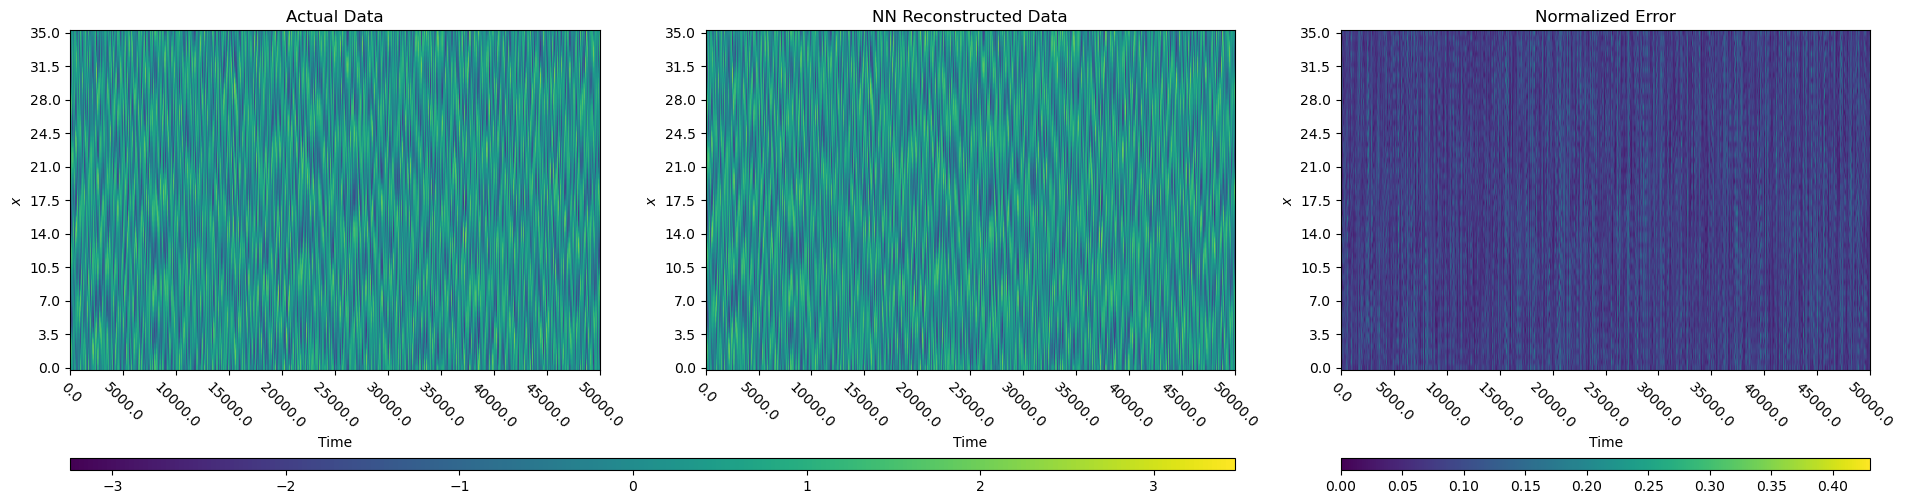

In [22]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_pod,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_poddata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [23]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_pod,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_poddata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [24]:
# time_to_plot = 20



# plot_reconstructed_data_KS(
#     boundary_idx_arr,
#     dir_name_pod,
#     all_data,
#     reconstructed_data, delta_t, xgrid,
#     save_figs=True,
#     normalization_constant_arr=normalization_constant_arr_poddata,
#     xticks_snapto=xticks_snapto,
#     num_yticks=11)

In [25]:
# create data
latent_states_all = (all_data - pod_centering_means) @ Wl

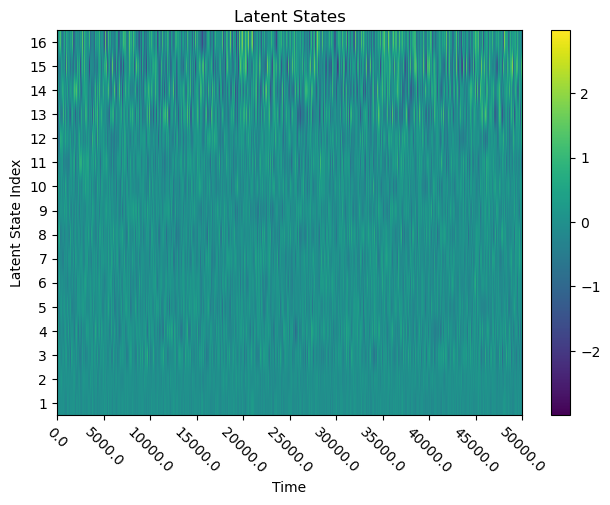

In [26]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_pod,
    xticks_snapto=xticks_snapto,
    num_yticks=16,
    save_figs=False)

In [27]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_pod,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [28]:
# ae_net.summary()

In [29]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 4
num_rows = (latent_states_all.shape[-1] + num_cols-1)//num_cols
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(num_rows, num_cols, sharex=False, figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    for j in range(latent_states_all.shape[-1]):
        row = j // num_cols
        col = j % num_cols
        ax[row, col].plot(input_time, latent_states_all[prev_idx:next_idx, j])
        # ax[j].plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
        # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
        # print(xticks)
        # ax[j].set_xticks(ticks=np.round(xticks*delta_t, 1))
        # ax[j].set_xticklabels('')
        ax[row, col].tick_params(axis='x', rotation=270+45)
        ax[row, col].set_ylabel('latent state {}'.format(j+1))
        ax[row, col].set_xlabel(r'Time$^+$')
        ax[row, col].grid(True)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    # ax[-1].set_xlabel(r'Time$^+$')
    # ax[0].legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    # ax.title.set_text(r'Case '+str(i+1))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Case '+str(i+1), size=16)
    
    fig.savefig(dir_name_pod+'/plots/LatentSpace-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
    
    print('')

    prev_idx = boundary_idx_arr[i]

# KE and Dissipation

In [30]:
save_dir = dir_name_pod+dir_sep+'plots'
# save_dir = None

In [31]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforpod_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_poddata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_poddata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_poddata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_poddata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr[i]

Case 1 - KE_nrmse : 0.013543184231363496


In [32]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr_og[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr_og[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr_og[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [33]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [34]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr[i]

Case 1 - D_nrmse : 0.18020909823341222


In [35]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr_og[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [36]:
np.savez(
    dir_name_pod+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [37]:
# x = np.linspace(-5, 5, 100)

# a = 1 #- np.exp(-2)

# modified_relu = lambda x : tf.keras.activations.relu(x+a).numpy()-a
# elu = lambda x : tf.keras.activations.elu(x)

# y1 = modified_relu(x)
# y2 = elu(x)

# plt.plot(x, y1, label='modified_relu')
# plt.plot(x, y2, label='elu')
# plt.legend()
# plt.grid(True)
# plt.show()

In [38]:
all_data_og_withoutpodnorm = rescaled_org_data
reconstructed_data_withoutpodnorm = rescaled_recon_data

In [39]:
FourierCoeffs_og = fft.fft(all_data_og_withoutpodnorm[:, 0:numpoints_xgrid], axis=1)
energySpectrum_og = FourierCoeffs_og.real**2 + FourierCoeffs_og.imag**2
energySpectrum_og = np.mean(energySpectrum_og, axis=0)

In [40]:
FourierCoeffs_recon = fft.fft(reconstructed_data_withoutpodnorm[:, 0:numpoints_xgrid], axis=1)
energySpectrum_recon = FourierCoeffs_recon.real**2 + FourierCoeffs_recon.imag**2
energySpectrum_recon = np.mean(energySpectrum_recon, axis=0)

In [41]:
meancentereddata_og = all_data_og_withoutpodnorm[:, 0:numpoints_xgrid] - np.mean(all_data_og_withoutpodnorm[:, 0:numpoints_xgrid], axis=0)
# covmat_og = np.matmul(meancentereddata_og.transpose(), meancentereddata_og, dtype=FTYPE) / (meancentereddata_og.shape[0] - 1)
covmat_og = (meancentereddata_og.transpose() @ meancentereddata_og) / FTYPE(meancentereddata_og.shape[0] - 1)
eigvals_og = np.abs(np.linalg.eigvals(covmat_og))
# eigvals_og = np.linalg.eigvals(covmat_og)
eigvals_og = np.sort(eigvals_og)
eigvals_og = eigvals_og[::-1]

print(meancentereddata_og.dtype)
print(meancentereddata_og.transpose().dtype)
print(covmat_og.dtype)
print(eigvals_og.dtype)

float32
float32
float32
float32


In [43]:
meancentereddata_recon = reconstructed_data_withoutpodnorm[:, 0:numpoints_xgrid] - np.mean(reconstructed_data_withoutpodnorm[:, 0:numpoints_xgrid], axis=0)
covmat_recon = np.matmul(meancentereddata_recon.transpose(), meancentereddata_recon) / FTYPE(meancentereddata_recon.shape[0] - 1)
eigvals_recon = np.abs(np.linalg.eigvals(covmat_recon))
# eigvals_recon = np.linalg.eigvals(covmat_recon)
eigvals_recon = np.sort(eigvals_recon)
eigvals_recon = eigvals_recon[::-1]

print(meancentereddata_recon.dtype)
print(meancentereddata_recon.transpose().dtype)
print(covmat_recon.dtype)
print(eigvals_recon.dtype)

float32
float32
float32
float32


In [44]:
# all_data_og += podcentering_means

In [45]:
print('Amount of energy contained in reconstructed data')
print('------------------------------------------------')
print('POD : {} %'.format(100*np.sum(energySpectrum_recon)/np.sum(energySpectrum_og)))

Amount of energy contained in reconstructed data
------------------------------------------------
POD : 98.91555786207023 %


In [46]:
k = fft.fftfreq(numpoints_xgrid, d=1/numpoints_xgrid)
idx = np.where(k<0)[0]
k[idx] += numpoints_xgrid
print(k)#*numpoints_xgrid*2*np.pi/xgrid[-1])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]


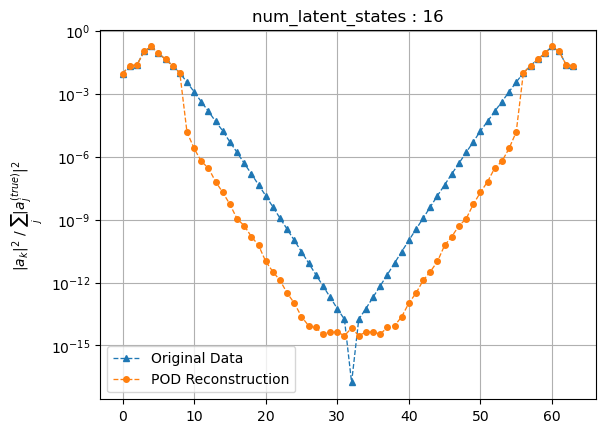

In [47]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
y2 = energySpectrum_recon/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
plt.semilogy(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
plt.semilogy(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='POD Reconstruction')
# plt.ylim([5e-2,None])
plt.title('num_latent_states : {}'.format(num_latent_dims))
plt.grid(True)
plt.legend()
plt.ylabel(r'$ \| a_k \|^2 \ / \ \sum_j \| a_j^{(true)} \|^2$')
plt.savefig(dir_name_pod+'/plots/FC_reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

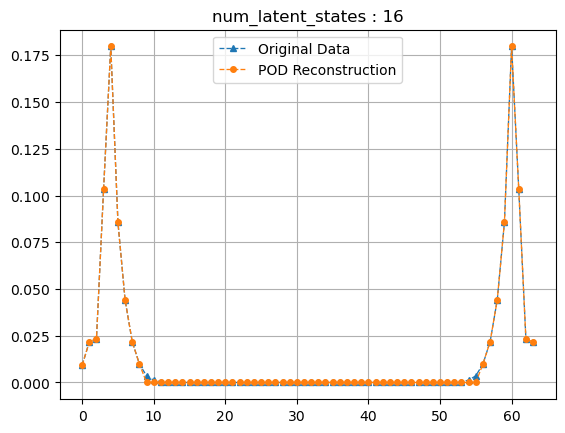

In [48]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
y2 = energySpectrum_recon/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
plt.plot(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
plt.plot(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='POD Reconstruction')
# plt.ylim([5e-2,None])
plt.title('num_latent_states : {}'.format(num_latent_dims))
plt.grid(True)
plt.legend()
plt.show()

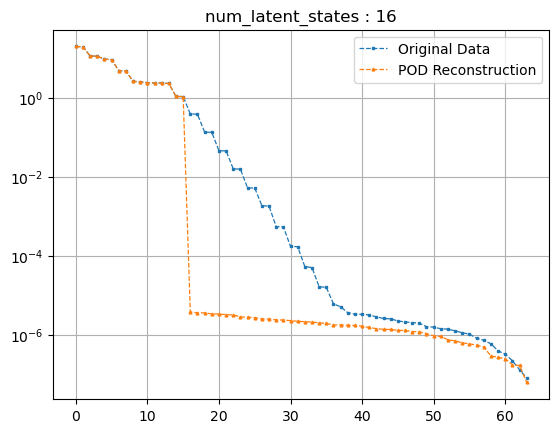

In [49]:
fig_eigvals, ax_eigvals = plt.subplots()
ax_eigvals.semilogy(eigvals_og, linestyle='--', marker='s', linewidth=0.9, markersize=2)
ax_eigvals.semilogy(eigvals_recon, linestyle='--', marker='^', linewidth=0.9, markersize=2)
ax_eigvals.grid(True)
ax_eigvals.legend([r'Original Data', r'POD Reconstruction'])
ax_eigvals.set_axisbelow(True)
ax_eigvals.set_title('Eigenvalues of the covariance matrix')
plt.title('num_latent_states : {}'.format(num_latent_dims))
plt.savefig(dir_name_pod+'/plots/eigvals_reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

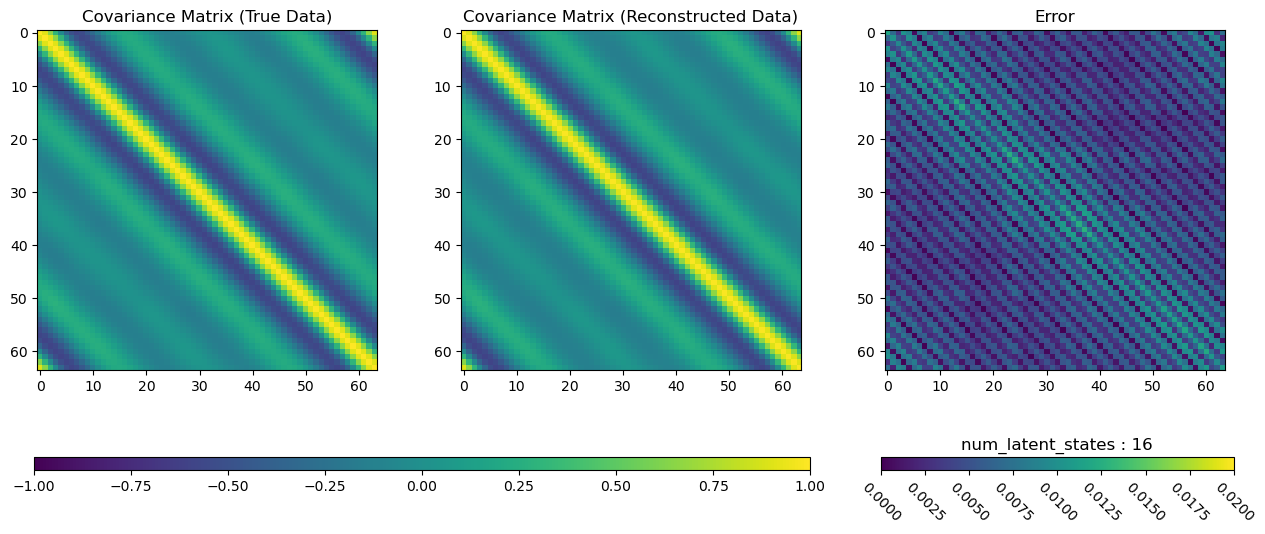

In [50]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()

fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
subplot1 = 1
subplot2 = subplot1 + 1

covmat_recon_normd = np.divide(np.transpose(covmat_recon), np.diag(covmat_og)).transpose()

vmin_snap = 0.05
vmax_snap = 0.05
vmin = np.min([
    covmat_og_normd.min(),
    covmat_recon_normd.min()
])
vmin = min(vmin, -1.0)
vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
vmax = np.max([
    covmat_og_normd.max(),
    covmat_recon_normd.max()
])
vmax = max(vmax, 1.0)
vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

# plotting the original data
ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
im_orig = ax_covmat_orig.imshow(
    covmat_og_normd,
    aspect='equal',
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
ax_covmat_orig.title.set_text('Covariance Matrix (True Data)')
# xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
# ax_covmat_orig.set_xticks(ticks=xticks)
# ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
# ax_covmat_orig.tick_params(axis='x', rotation=270+45)
# yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
# yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
# ax_covmat_orig.set_yticks(ticks=yticks)
# ax_covmat_orig.set_yticklabels(yticklabels)
# ax_covmat_orig.set_xlabel(xlabel)
# ax_covmat_orig.set_ylabel(ylabel)

# plotting the predicted data
ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
im_predict = ax_covmat_predict.imshow(
    covmat_recon_normd,
    aspect='equal',
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
ax_covmat_predict.title.set_text('Covariance Matrix (Reconstructed Data)')
# ax_covmat_predict.tick_params(axis='x', rotation=270+45)
# ax_covmat_predict.set_xlabel(xlabel)
# ax_covmat_predict.set_ylabel(ylabel)

# subplots adjustment to account for colorbars
fig_covmat.subplots_adjust(
    bottom=0.2,
    left=0.1,
)

# original data and recon data colorbar
cb_xbegin = ax_covmat_orig.transData.transform([0, 0])
cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
cb_xend = ax_covmat_predict.transData.transform([covmat_recon_normd.shape[-1], 0])
cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

# computing the normalized error
subplot3 = subplot2+1
error = np.abs(covmat_og_normd-covmat_recon_normd)
vmax_error_snap = 0.02
vmax_error = np.max(error)
vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
# error = 100*error / np.abs(pod_covmat_dataout)
# plotting the normalized error
ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
im_error = ax_covmat_error.imshow(
    error,
    aspect='equal',
    origin='upper',
    vmin=0.0,
    vmax=vmax_error
)
ax_covmat_error.title.set_text(r'Error')
# ax_error.tick_params(axis='x', rotation=270+45)
# ax_error.set_xlabel(xlabel)
# ax_error.set_ylabel(ylabel)

# error colorbar
cbe_xbegin = ax_covmat_error.transData.transform([0, 0])
cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
cbe_xend = ax_covmat_error.transData.transform([covmat_recon_normd.shape[-1], 0])
cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
error_cb_ax.tick_params(axis='x', rotation=270+45)
cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')
plt.title('num_latent_states : {}'.format(num_latent_dims))
plt.savefig(dir_name_pod+'/plots/covmat_error.png', dpi=300, bbox_inches='tight')
plt.show()